In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features


In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data=np.load(path+'Data_train_all.npz')
    Features_audio=Train_data['arr_2']
    Labels=Train_data['arr_1']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_audio = Features_audio[randomize]
    
    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    Features_audio = np.split(Features_audio,[Features_audio.shape[0] - 2000])

    return new_Labels[0],Features_audio[0].astype(np.float64),new_Labels[1],Features_audio[1].astype(np.float64)

def get_test_data(path=path):
    Train_data=np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Features_audio=Train_data[2]
    Labels=Train_data[1]

    Labels = one_hot_encoding(Labels)

    return Labels,Features_audio.astype(np.float64)

In [4]:
Labels,Features_audio,Labels2,Features_audio2 = get_train_and_validate_data()
print(Labels.shape,Features_audio.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_audio2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_audio3 = get_test_data()
print(Labels3.shape,Features_audio3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(9976, 7) (9976, 193)
Train Classes distribution:  [1535. 1970. 1105. 1533. 1057. 1490. 1286.]
(2000, 7) (2000, 193)
Validate Classes distribution:  [298. 390. 203. 315. 215. 289. 290.]
(1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# Audio Model

In [5]:
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                       decay=0.0, amsgrad=False)

num_classes = 7


def build_scrath_sound_model_layers_diff():
    
    print('building the model ... ')
    
    model = Sequential()
    model.add(Dense(256, input_shape=(193,), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])
    return model

In [6]:
sound_model = build_scrath_sound_model_layers_diff()

building the model ... 


In [7]:
sound_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
OUTPUT (Dense)               (None, 7)                 455       
Total params: 157,063
Trainable params: 157,063
Non-trainable params: 0
__________________________________________________

In [8]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/audio_model_checkpoint'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [9]:
import time
start_time = time.time()

epochs = 500
batch_size=128

learning_hist=sound_model.fit(Features_audio, Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=(Features_audio2,Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.32450, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.32450 to 0.54150, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.54150 to 0.69950, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.69950 to 0.76000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.76000 to 0.78550, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.78550 to 0.81000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.81000 to 0.82050, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.82050 to 0.84000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy did not improve from 0.84000


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy did not improve from 0.84000


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.84000 to 0.87050, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy improved from 0.87050 to 0.89100, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.89100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.89100


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy improved from 0.89100 to 0.90650, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy did not improve from 0.90650


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy improved from 0.90650 to 0.91000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy improved from 0.91000 to 0.93850, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy improved from 0.93850 to 0.94800, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.94800


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy improved from 0.94800 to 0.95250, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy improved from 0.95250 to 0.95500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy improved from 0.95500 to 0.95900, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy did not improve from 0.95900


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy improved from 0.95900 to 0.96400, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy improved from 0.96400 to 0.96550, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.96550


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy did not improve from 0.96550


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00029: val_accuracy improved from 0.96550 to 0.97150, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00030: val_accuracy did not improve from 0.97150


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00031: val_accuracy improved from 0.97150 to 0.97400, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00032: val_accuracy did not improve from 0.97400


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00033: val_accuracy improved from 0.97400 to 0.97750, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00034: val_accuracy did not improve from 0.97750


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00035: val_accuracy did not improve from 0.97750


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00036: val_accuracy did not improve from 0.97750


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00037: val_accuracy did not improve from 0.97750


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00038: val_accuracy improved from 0.97750 to 0.98500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00039: val_accuracy did not improve from 0.98500


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00040: val_accuracy did not improve from 0.98500


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00041: val_accuracy did not improve from 0.98500


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00042: val_accuracy did not improve from 0.98500


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00043: val_accuracy improved from 0.98500 to 0.99150, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\audio_model_checkpoint\assets


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00044: val_accuracy did not improve from 0.99150


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00045: val_accuracy did not improve from 0.99150


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00046: val_accuracy did not improve from 0.99150


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00047: val_accuracy did not improve from 0.99150


  0%|          | 0.00/78.0 [00:00<?, ?batch/s]


Epoch 00048: val_accuracy did not improve from 0.99150
---Time 29.75739884376526 seconds ---


In [10]:
from keras.models import load_model

sound_model = load_model(model_path)

In [11]:
#Train Accuracy
sound_model.evaluate(Features_audio,Labels)

312/312 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9895


[0.03268859535455704, 0.9894747138023376]

In [12]:
#valid Accuracy
sound_model.evaluate(Features_audio2,Labels2)

63/63 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9915


[0.038043029606342316, 0.9915000200271606]

In [13]:
#Test Accuracy
sound_model.evaluate(Features_audio3,Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.3138 - accuracy: 0.9274


[0.3137914836406708, 0.9273783564567566]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


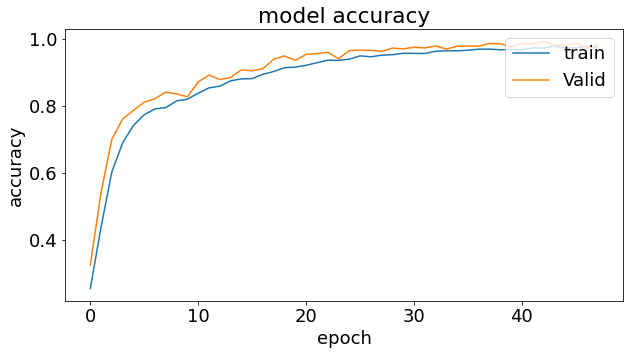

In [14]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()


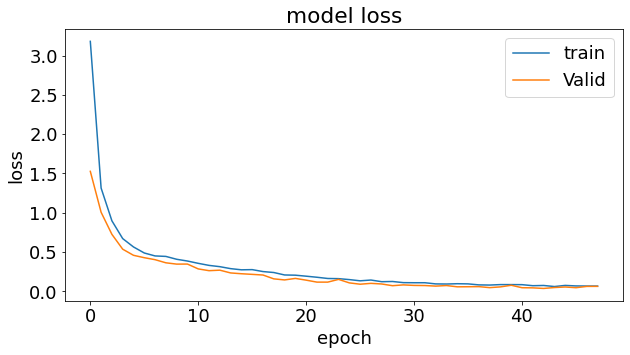

In [15]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()